In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import shap
import matplotlib.pyplot as plt 
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error 

plt.style.use('seaborn')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

SEED = 13
seed_everything(SEED)

# Loading Data

In [3]:
df_train = pd.read_csv('data/train.csv') # index_col='date'
df_test = pd.read_csv('data/test.csv') # index_col='date'

df_train['date'] = pd.to_datetime(df_train.date)
df_test['date'] = pd.to_datetime(df_test.date)

# Time Series Cross Validation

In [4]:
def performTimeSeriesCV(df_train, target, number_folds, model, metric, kwargs={}):
    dates = df_train.date.unique()
    k = len(dates) // number_folds

    metrics = []
 
    for i in range(1, number_folds):
        train_index = dates[:(k * i)]
        
        if i == number_folds - 1:
            val_index = dates[(k * i):]
        else:
            val_index = dates[(k * i):(k * (i + 1))]
        
        train = df_train[df_train.date.isin(train_index)]
        val = df_train[df_train.date.isin(val_index)]
       
        X_train = train.drop(columns=['date', 'target_revenue', 'target_income'])     
        y_train = train[target]

        X_val = val.drop(columns=['date', 'target_revenue', 'target_income']).values     
        y_val = val[target].values
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        metrics.append(metric(y_val, model.predict(X_val),))
   
    return metrics

In [5]:
def SMAPE(y_true, y_pred):
    return (100 / y_true.size) * np.sum(2 * np.abs(y_pred - y_true) / (abs(y_true) + abs(y_pred)))

# Baseline

У нас в задаче две целевые переменные: revenue и income. Однако из-за того, что у них очень высокая корреляция, чтобы не дублировать весь код пока будем прогнозировать только Revenue. Когда определим оптимальную модель для revenue (оптимальные признаки и оптимальные гиперпараметры), то просто обучим такую же модель для income.

В качестве бейзлайн модели построим CatBoost с гиперпамраметрами по умолчанию.

In [6]:
cat_features = ['Company']
for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')

In [7]:
CBr_baseline = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                                 random_seed=SEED, verbose=False)

smape_baseline_cv = performTimeSeriesCV(df_train, 'target_revenue', 3, CBr_baseline, SMAPE)

In [8]:
print(f'Mean SMAPE of base model on cross validation: {round(np.mean(smape_baseline_cv), 4)}')

Mean SMAPE of base model on cross validation: 59.5057


In [9]:
for cat_feature in cat_features:
    df_test[cat_features] = df_test[cat_features].astype('category')
    
X_test = df_test.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test = df_test['target_revenue']

In [10]:
smape_baseline_test = SMAPE(y_test, CBr_baseline.predict(X_test))

print(f'Mean SMAPE of base model on test: {round(np.mean(smape_baseline_test), 4)}')

Mean SMAPE of base model on test: 59.8275


Итоговое качество бейзлан модели: CatBoost на изначальных признаках с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **59.5057**
- *SMAPE на тесте:* **59.8275**

# Improving baseline model

## Additional Features Generation

Для начала сгенерируем два календарных категориальных признака: квартал и год. Создание дополнительных календарных признаков кажется здесь лишним.

In [11]:
df_train['quarter'] = df_train.date.dt.quarter
df_train['year'] = df_train.date.dt.year

df_test['quarter'] = df_test.date.dt.quarter
df_test['year'] = df_test.date.dt.year

In [12]:
cat_features.extend(['quarter', 'year'])

for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')
    df_test[cat_features] = df_test[cat_features].astype('category')

Создадим функцию по генерации дополнительных количественных признаков

In [13]:
def percentile(n):
    """Calculate n - percentile of data"""

    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "pctl%s" % n
    return percentile_


def generate_features(
    df,
    target_var,
    all_id_columns=['date', 'Company'],
    org_id_columns=["Company"],
    windows=[4, 8],
    aggregation_methods={"mean", "median", "max", "min"}, # percentile(10), percentile(90)
):
    out_df = df.copy(deep=True)
    for w in tqdm(windows):
        lf_df = (
            df
            .set_index(all_id_columns)[target_var]
            .groupby(level=org_id_columns)
            .apply(
                lambda x: x.rolling(window=w, min_periods=1).agg(
                    aggregation_methods
                )
            )
        )
        
        lf_df.columns = lf_df.columns.to_flat_index()
        new_names = {x: "wdw{0}_{1}_{2}".format(w, x[0], x[1]) for x in lf_df.columns}
        lf_df = lf_df.reset_index().rename(columns=new_names)
        
        out_df = pd.merge(
            out_df, lf_df, how="left", on=all_id_columns
        )


    return out_df

In [14]:
quant_features = ['Revenue', 'Operating Income', 'Total Equity', 'Cash from Operations',
                  'Cash from Investing Activities', 'Cash from Financing Activities']

df = pd.concat([df_train, df_test], axis=0).sort_values(by=['Company', 'date'])
df_features = generate_features(df, quant_features).sort_values(by=['Company', 'date'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
dates = sorted(df.date.unique())

df_train_features = df_features[df_features.date.isin(dates[:37])]
df_test_features = df_features[df_features.date.isin(dates[37:41])]

Обучим модель с новыми сгенерированными признаками

In [16]:
CBr_features = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                                 random_seed=SEED, verbose=False)

smape_features_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features, SMAPE)

In [17]:
print(f'Mean SMAPE of model with additional features on cross validation: {round(np.mean(smape_features_cv), 4)}')

Mean SMAPE of model with additional features on cross validation: 43.3633


In [18]:
X_test_features = df_test_features.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test_features = df_test_features['target_revenue']

In [19]:
smape_features_test = SMAPE(y_test_features, CBr_features.predict(X_test_features))

print(f'Mean SMAPE of model with additional features on test: {round(np.mean(smape_features_test), 4)}')

Mean SMAPE of model with additional features on test: 49.6803


Итоговое качество модели со сгенерированными признаками с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **43.3633**
- *SMAPE на тесте:* **49.6803**

Как можно увидеть, удалось добиться существенного прироста в качестве по сравнению с бейзлайном

## Searching for Optimal Hyperparameters

Подбор параметров я осуществляю не просто чрез grid search, а по следующей схеме:
1. Выбираем относительно большой lr [0.05, 0.3], подбираем оптимальное кол-во деревьев для выбранного lr.
2. Настраиваем параметры, начиная с самых значимых (depth, l2_leaf_reg).
3. Уменьшаем lr, пропорционально увеличиваем число деревьев.

Внизу продемонстрирована уже последняя итерация подбора.

In [20]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

cat_dict = {'learning_rate': [0.15, 0.075, 0.05, 0.015],
            'iterations': [100, 150, 200, 300, 1000]}

grid = ParameterGrid(cat_dict)
grid_results = {}
optim_smape = 1000

for params in tqdm(grid):
    CBr_grid = CatBoostRegressor(loss_function='MAPE', depth=10, l2_leaf_reg=2,
                                 random_strength=1, cat_features=cat_features,
                                 random_seed=SEED, verbose=False, **params)
    
    smape = np.mean(performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_grid, SMAPE))
    
    grid_results[smape] = params
    print(smape, params)
    if smape < optim_smape:
        optim_smape = smape

optim_smape, grid_results[optim_smape]

  0%|          | 0/20 [00:00<?, ?it/s]

44.597764516324524 {'iterations': 100, 'learning_rate': 0.15}
45.93300500768526 {'iterations': 100, 'learning_rate': 0.075}
47.372620959596574 {'iterations': 100, 'learning_rate': 0.05}
57.3453790317498 {'iterations': 100, 'learning_rate': 0.015}
44.597764516324524 {'iterations': 150, 'learning_rate': 0.15}
45.15397517944387 {'iterations': 150, 'learning_rate': 0.075}
43.81911585051691 {'iterations': 150, 'learning_rate': 0.05}
50.82211954794373 {'iterations': 150, 'learning_rate': 0.015}
47.05958263521305 {'iterations': 200, 'learning_rate': 0.15}
45.74640714939446 {'iterations': 200, 'learning_rate': 0.075}
43.031820627988104 {'iterations': 200, 'learning_rate': 0.05}
45.01849830407363 {'iterations': 200, 'learning_rate': 0.015}
47.05958263521305 {'iterations': 300, 'learning_rate': 0.15}
45.74640714939446 {'iterations': 300, 'learning_rate': 0.075}
43.031820627988104 {'iterations': 300, 'learning_rate': 0.05}
42.4503784154357 {'iterations': 300, 'learning_rate': 0.015}
47.0595826352

(39.63932964344434, {'iterations': 1000, 'learning_rate': 0.015})

Итоговые оптимальные гиперпараметры следующие:
- learning_rate: 0.015
- iterations: 1000
- depth: 10
- l2_leaf_reg: 2
- random_strength: 1

Посмотрим на качество полученной модели

In [21]:
opt_hyperparams = {
    'learning_rate': 0.015,
    'iterations': 1000,
    'depth': 10,
    'l2_leaf_reg': 2,
    'random_strength': 1
}

In [22]:
CBr_features_opt = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features,
                                     random_seed=SEED, verbose=False, **opt_hyperparams)

smape_features_opt_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features_opt, SMAPE)

In [23]:
print(f'Mean SMAPE of optimal model with additional features on cross validation: ' 
      f'{round(np.mean(smape_features_opt_cv), 4)}')

Mean SMAPE of optimal model with additional features on cross validation: 39.6393


In [24]:
smape_features_opt_test = SMAPE(y_test_features, CBr_features_opt.predict(X_test_features))

print(f'Mean SMAPE of optimal model with additional features on test: {round(np.mean(smape_features_opt_test), 4)}')

Mean SMAPE of optimal model with additional features on test: 37.0819


Итоговое качество модели со сгенерированными признаками и оптимальными гиперпараметрами следующее
- *SMAPE по CV с 3 фолдами:* **38.8362**
- *SMAPE на тесте:* **41.2173**

Благодаря подбору оптимальных гиперпараметров, удалось осуществить ещё один скачок в приросте качества.

Финальные результаты представлены в таблице ниже:

| Metrics       | Baseline | Additional Features | Features + optimal hyperparameters |
|---------------|----------|---------------------|------------------------------------|
| SMAPE CV, k=3 | 59.5057  | 43.3633             | 38.8362                            |
| SMAPE Test    | 59.8275  | 49.6803             | 41.2173                            |



# Final Model Interpretation

In [25]:
shap_values = CBr_features_opt.get_feature_importance(
    Pool(X_test_features, label=y_test_features,cat_features=cat_features),
    type="ShapValues"
)

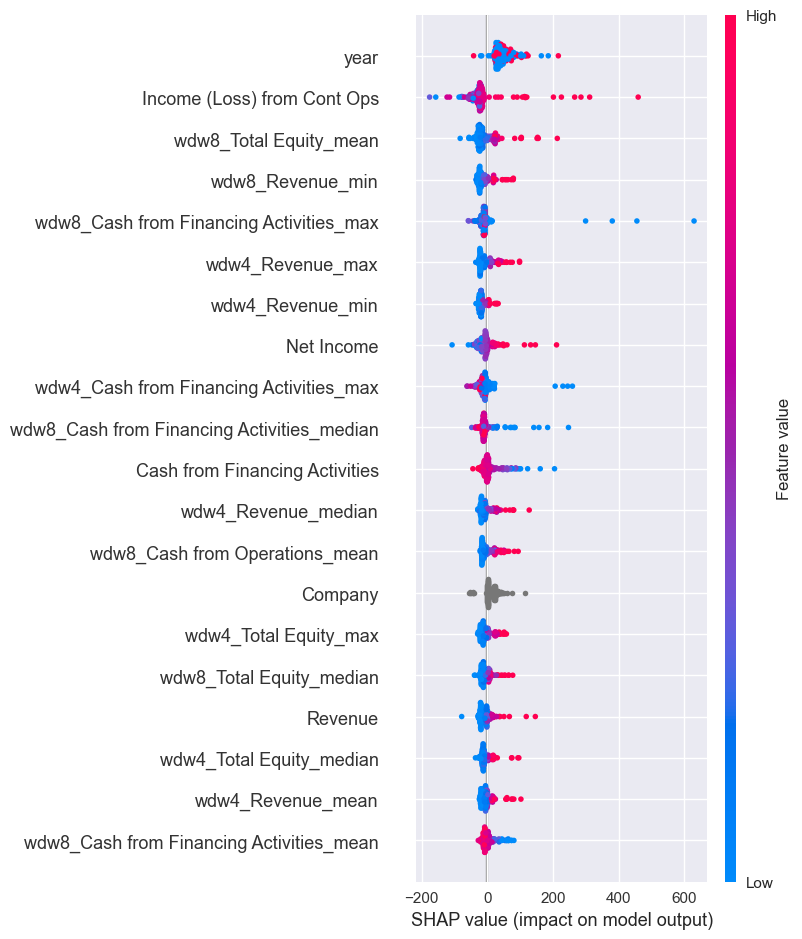

In [26]:
shap.summary_plot(shap_values[:,:-1], X_test_features)

P. S. wnw{n} - означает, что показатель рассчитывался по n последним кварталам. Например, wnw8_Cash from Investing Activities_median означает среднее значение Cash from Investing Activities за последние 8 кварталов, то есть за последние 2 года.